In [1]:
# packages and import
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

In [3]:
# simulation constants
LABELS = 10
WIDTH = 28
CHANNELS = 1

VALID = 10000

STEPS = 3500
BATCH = 100
PATCH = 5
DEPTH = 8
HIDDEN = 100

LR = 0.001

In [4]:
# import training data
df_train = pd.read_csv("./train.csv")
labels = np.array(df_train.pop('label'))

In [5]:
# data preprocessing
labels = LabelEncoder().fit_transform(labels)[:, None]
labels = OneHotEncoder().fit_transform(labels).todense()
df_train = StandardScaler().fit_transform(np.float32(df_train.values))
df_train = df_train.reshape(-1, WIDTH, WIDTH, CHANNELS)  # reshape train data into 2d images
train_data, valid_data = df_train[: -VALID], df_train[-VALID:]
train_labels, valid_labels = labels[: -VALID], labels[-VALID:]

print('train data shape = ' + str(train_data.shape) + ' = (TRAIN, WIDTH, WIDTH, CHANNELS)')
print('labels shape = ' + str(labels.shape) + ' = (TRAIN, LABELS)')

/Users/congcong/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/Users/congcong/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='

train data shape = (32000, 28, 28, 1) = (TRAIN, WIDTH, WIDTH, CHANNELS)
labels shape = (42000, 10) = (TRAIN, LABELS)
train data shape = (32000, 28, 28, 1) = (TRAIN, WIDTH, WIDTH, CHANNELS)
labels shape = (42000, 10) = (TRAIN, LABELS)


In [6]:
# model construction with tensorflow
tf_data = tf.placeholder(tf.float32, shape=(None, WIDTH, WIDTH, CHANNELS))    # tensor
tf_labels = tf.placeholder(tf.float32, shape=(None, LABELS))    # tensor

In [7]:
#.4 layered network consisting 2 conv with weights and biases (w1, b1) and (w2, b2), 
# followed by a fully connected hidden layer (w3, b3) with hidden nurons 
# and an output layer (w4, b4) with 10 output nodes (one-hot encoding)

w1 = tf.Variable(tf.truncated_normal([PATCH, PATCH, CHANNELS, DEPTH], stddev=0.1))
b1 = tf.Variable(tf.zeros([DEPTH]))

w2 = tf.Variable(tf.truncated_normal([PATCH, PATCH, DEPTH, 2*DEPTH], stddev=0.1))
b2 = tf.Variable(tf.constant(1.0, shape=[2*DEPTH]))

w3 = tf.Variable(tf.truncated_normal([WIDTH//4 * WIDTH // 4 *2*DEPTH, HIDDEN], stddev=0.1))
b3 = tf.Variable(tf.constant(1.0, shape=[HIDDEN]))

w4 = tf.Variable(tf.truncated_normal([HIDDEN, LABELS], stddev=0.1))
b4 = tf.Variable(tf.constant(1.0, shape=[LABELS]))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Colocations handled automatically by placer.


In [8]:
def logits(data):
    # Convolutional layer 1
    x = tf.nn.conv2d(data, w1, [1, 1, 1, 1], padding='SAME')
    x = tf.nn.max_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    x = tf.nn.relu(x + b1)
    
    # Convolutional layer 2
    x = tf.nn.conv2d(x, w2, [1, 1, 1, 1], padding = 'SAME')
    x = tf.nn.max_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    x = tf.nn.relu(x + b2)
    
    # Fully connected layer
    x = tf.reshape(x, (-1, WIDTH // 4 * WIDTH // 4 * 2 * DEPTH))
    x = tf.nn.relu(tf.matmul(x, w3) + b3)
    return tf.matmul(x, w4) + b4

# Prediction
tf_pred = tf.nn.softmax(logits(tf_data))

In [9]:
# using the categorical cross entropy loss for training the model
# Gradient Descent Optimizer with/without decaying learning rate  or Adam/RMSProp
tf_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits(tf_data), labels=tf_labels))
tf_acc = 100 * tf.reduce_mean(tf.to_float(tf.equal(tf.argmax(tf_pred, 1), tf.argmax(tf_labels, 1))))

tf_opti = tf.train.RMSPropOptimizer(LR)
tf_step = tf_opti.minimize(tf_loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


In [10]:
# train
# open the session

init = tf.global_variables_initializer()
session = tf.Session()
session.run(init)

In [14]:
ss = ShuffleSplit(n_splits=STEPS, train_size=BATCH)
ss.get_n_splits(train_data, train_labels)
history = [(0, np.nan, 10)]
for step, (idx, _) in enumerate(ss.split(train_data, train_labels), start=1):
    fd = {tf_data: train_data[idx], tf_labels: train_labels[idx]}
    session.run(tf_step, feed_dict=fd)
    if step%500 == 0:
        fd = {tf_data: valid_data, tf_labels: valid_labels}
        valid_loss, valid_accuracy = session.run([tf_loss, tf_acc], feed_dict=fd)
        history.append((step, valid_loss, valid_accuracy))
        print("Step %i \t Valid. Acc. = %f" %(step, valid_accuracy), end='\n')

Step 500 	 Valid. Acc. = 98.369995
Step 500 	 Valid. Acc. = 98.369995
Step 1000 	 Valid. Acc. = 98.430000
Step 1000 	 Valid. Acc. = 98.430000
Step 1500 	 Valid. Acc. = 98.439995
Step 1500 	 Valid. Acc. = 98.439995
Step 2000 	 Valid. Acc. = 98.199997
Step 2000 	 Valid. Acc. = 98.199997
Step 2500 	 Valid. Acc. = 98.509995
Step 2500 	 Valid. Acc. = 98.509995
Step 3000 	 Valid. Acc. = 98.369995
Step 3000 	 Valid. Acc. = 98.369995
Step 3500 	 Valid. Acc. = 98.549995
Step 3500 	 Valid. Acc. = 98.549995


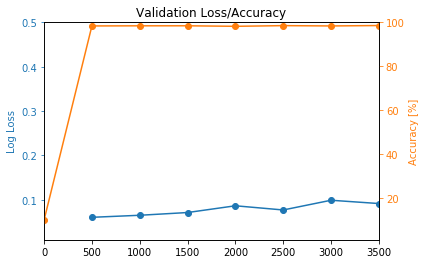

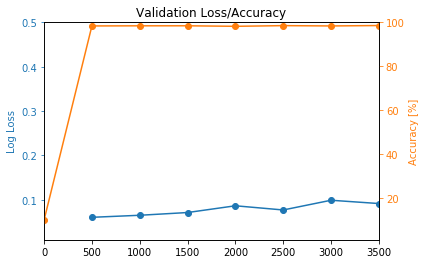

In [19]:
# visualize the trainning history
steps, loss, acc = zip(*history)
fig = plt.figure()
plt.title("Validation Loss/Accuracy")
ax_loss = fig.add_subplot(111)
ax_acc = ax_loss.twinx()
plt.xlabel("Training Steps")
plt.xlim(0, max(steps))

ax_loss.plot(steps, loss, '-o', color='C0')
ax_loss.set_ylabel('Log Loss', color='C0')
ax_loss.tick_params('y', colors='C0')
ax_loss.set_ylim(0.01, 0.5)

ax_acc.plot(steps, acc, '-o', color='C1')
ax_acc.set_ylabel('Accuracy [%]', color='C1')
ax_acc.tick_params('y', colors='C1')
ax_acc.set_ylim(1, 100)

plt.show()

In [23]:
# start the prediction
df_test = pd.read_csv('./test.csv')
df_test = StandardScaler().fit_transform(np.float32(df_test.values))
test_data = df_test.reshape(-1, WIDTH, WIDTH, CHANNELS)

In [24]:
test_pred = session.run(tf_pred, feed_dict={tf_data: test_data})
test_labels = np.argmax(test_pred, axis=1)

Label Prediction: 5
Label Prediction: 5


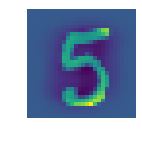

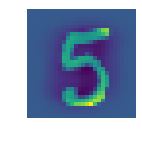

In [27]:
# plot an example
k = 10
print("Label Prediction: %i" %test_labels[k])
fig = plt.figure(figsize=(2, 2))
plt.axis('off')
plt.imshow(test_data[k, :, :, 0])
plt.show()

In [29]:
submission = pd.DataFrame(data={'ImageId': (np.arange(test_labels.shape[0])+1), 'Label': test_labels})
submission.to_csv('submission.csv', index=False)
submission.tail()

,ImageId,Label
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
27999,28000,2


,ImageId,Label
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
27999,28000,2


In [30]:
session.close()